# Generating the dataset from the pdb

In [15]:
from src.data_prep import run, get_id_and_ressolution, augment_dataset, get_all_files_and_ids, download_all_pdbs
from src.dataset import AminoAcidDataset
from torch.utils.data import DataLoader
import json
import matplotlib.pyplot as plt
import os

## 1. Downloading and extracting resolution information from the PDBs

In [16]:
# Downlaod 
# download_all_pdbs("data/all_pdbs")

In [17]:
# Extract the saved pdb file paths and ids
pdb_files, pdb_ids = get_all_files_and_ids()
print(f"Found {len(pdb_files)} PDB files")

subset_ids = pdb_ids[:1000] # Cutoff to 5000 for now
subset_files = pdb_files[:1000] # Cutoff to 5000 for now

pdb_resolution = get_id_and_ressolution(subset_ids, subset_files, batch_size=40)


Found 38574 PDB files


Of the 1000 PDB files, 909 have a resolution value
Considering only files with a resolution of less than 6, we have 904 files


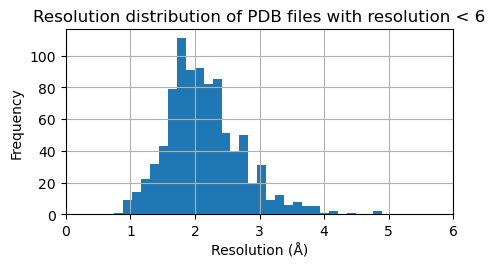

In [18]:
print(f"Of the {len(pdb_resolution)} PDB files, {len([k for k, v in pdb_resolution.items() if v is not None])} have a resolution value")
print(f"Considering only files with a resolution of less than 6, we have {len([k for k, v in pdb_resolution.items() if v is not None and v < 6])} files")

plotable_dict = {k: v for k, v in pdb_resolution.items() if v is not None and v < 6}
plt.figure(figsize=(5,2.4))
plt.hist(plotable_dict.values(), bins=30)
plt.xlim(0,6)
plt.xlabel("Resolution (Å)")
plt.ylabel("Frequency")
plt.title("Resolution distribution of PDB files with resolution < 6")
plt.grid()
plt.show()

## 2. Extracting all amino acids from the PDB-files and sorting datasets with different resolutions

In [19]:
# Extract all amino acids at a ressolution cutoff and save to file
def get_all_amino_acids_with_resolution(target_resolution, output_path):
    """Get all amino acids from pdb files with a resolution less than target_resolution and save to output_path

    Args:
        target_resolution (float): The target resolution
        output_path (str): The path to save the amino acids to

    Returns:
        None
    """

    # Get the pdb ids with a resolution of less than target_resolution
    pdb_ids = {k: v for k, v in pdb_resolution.items() if v is not None and v < target_resolution}
    # Get all pdb files where the file name contains any of the pdbids
    pdb_files = [f for f in subset_files if any(p.upper() in f.upper() for p in pdb_ids)]
    # Get the amino acids from the pdb files
    pdb_info = [*zip(pdb_ids, pdb_files)]
    # Run the amino acid extraction and save to file
    print(f"Extracting amino acids with resolution < {target_resolution} from {len(pdb_info)} PDB files")
    run(pdb_info=pdb_info, out_path=output_path ,download=True)

# res cutoff 2.0
get_all_amino_acids_with_resolution(2.0, 'data/amino_acids_2_0A.pdb')

# res cutoff 1.5
get_all_amino_acids_with_resolution(1.5, 'data/amino_acids_1_5A.pdb')


Extracting amino acids with resolution < 2.0 from 402 PDB files
Saving to data/amino_acids_2_0A.pdb
Extracting amino acids with resolution < 1.5 from 84 PDB files
Saving to data/amino_acids_1_5A.pdb


## 3. Processing and augmenting the dataset

Here we use go through 2 steps:
1. We load the amino acid dataset with, raw extracted amino acids from the file
2. We apply processing to these amino acids:
   - In the first step the amino acids are centered at the origin with their first atom (backbone N)
   - In the second step if n_orientations > 1, we will apply random transformations to the residue and save n copies of the residue to augment the data.
  
For the augemntation of the dataset we apply 3 random transorfmations in x, y and z with random angles phi, psi, theta by applying rotational matrices.

In [ ]:
# Load the Dataset and create a torch Dataloader
dataset = AminoAcidDataset('data/amino_acids_2_0A.pdb')
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
# Now we process the dataset using the augment_dataset function
augment_dataset(dataset, 'data/amino_acids_2_0A_augmented.pdb',2)

# Now for the 1.5 Å dataset
dataset = AminoAcidDataset('data/amino_acids_1_5A.pdb')
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
augment_dataset(dataset, 'data/amino_acids_1_5A_augmented.pdb',5)

### How do we center and augment the residues?

First we center the residue with its first atom at the origin.
Then if selected, random 3D rotation is applied. The transformation is implemented in python by applying a transformation matrix like so (here x axis):
```python
theta = torch.deg2rad(torch.tensor(theta))
rotation_matrix = torch.tensor([[torch.cos(theta), -torch.sin(theta), 0],
                                [torch.sin(theta), torch.cos(theta), 0],
                                [0, 0, 1]])
```
Below you can see a visual representation of what a 10 degree rotation around the x-axis may look like

tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.2850,  0.6550,  1.3570],
        [ 0.4560,  2.1960,  1.3210],
        [ 1.8570,  2.6070,  0.6920],
        [ 3.2400,  2.0510,  1.7160],
        [ 4.5790,  2.7540,  0.8150],
        [-0.7220,  0.2220,  2.3790],
        [-0.3440, -0.3000,  3.4630]])


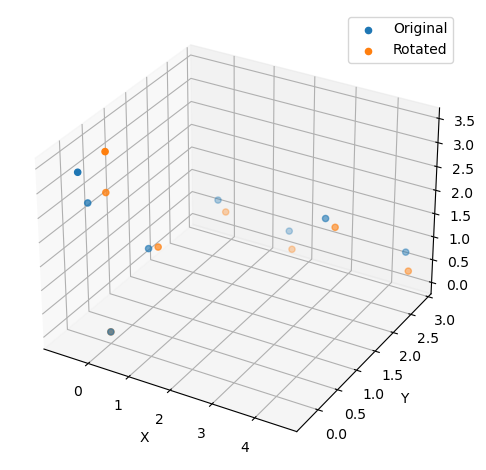

In [14]:
import torch
from src.data_prep import center_residue_to_first_atom, rotate_residue

# Rotate this molecule with 3D coordinates
residue = torch.tensor([[ -5.0390,  22.5140, -14.6070],
                        [ -4.7540,  23.1690, -13.2500],
                        [ -4.5830,  24.7100, -13.2860],
                        [ -3.1820,  25.1210, -13.9150],
                        [ -1.7990,  24.5650, -12.8910],
                        [ -0.4600,  25.2680, -13.7920],
                        [ -5.7610,  22.7360, -12.2280],
                        [ -5.3830,  22.2140, -11.1440]])
def plot_residue(coordinates):
    ax.scatter(coordinates[:, 0], coordinates[:, 1], coordinates[:, 2])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

# Center the coordinates to the first atom
centered_residue = center_residue_to_first_atom(residue)
# Rotate the residue
rotated_resid = rotate_residue(centered_residue, 10,0,0)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plot_residue(centered_residue)
plot_residue(rotated_resid)
plt.legend(['Original', 'Rotated'])
plt.tight_layout()
plt.show()